Kaggle
# Titanic - Machine Learning from Disaster

In [2]:
import pandas as pd
import numpy as np

In [3]:
def import_file(filename):
    df = pd.read_csv(filename)
    return df

In [4]:
def fill_age(row, df):
    condition = ((df['Sex'] == row['Sex']) & (df['Pclass'] == row['Pclass']))
    return df[condition]['Age'].values[0]

In [5]:
def fill_fare(row, df):
    condition = ((df['Sex'] == row['Sex']) & (df['Pclass'] == row['Pclass']))
    return df[condition]['Fare'].values[0]

In [94]:
from collections import Counter
def clean_data(df):
    # 687 rows have null entry for Cabin - set this to None
    # then append column with first character from cabin as this may has some relevance e.g. which deck it's on
    df['Cabin'] = df['Cabin'].replace(np.nan, 'None')
    df['CabinType'] = df['Cabin'].astype(str).str[0]
    
    # 177 rows have null entry for Age
    # to populate the blanks, first determine the median entry by sex and class
    grouped_df = df.groupby(['Sex', 'Pclass'])
    grouped_df_median = grouped_df.median()
    grouped_df_median = grouped_df_median.reset_index()[['Sex', 'Pclass', 'Age']]
    df['Age'] = df.apply(lambda row: fill_age(row, grouped_df_median) if np.isnan(row['Age']) else row['Age'], axis = 1)

    # do the same for rows with blank Fare (there aren't any in the training data, but there are in the test data)
    grouped_df_median = grouped_df.median()
    grouped_df_median = grouped_df_median.reset_index()[['Sex', 'Pclass', 'Fare']]
    df['Fare'] = df.apply(lambda row: fill_fare(row, grouped_df_median) if np.isnan(row['Fare']) else row['Fare'], axis = 1)

    # 2 rows have null entry for Embarked
    # populate with the most frequent value
    lst = list(df['Embarked'])
    data = Counter(lst)
    most_common = max(lst, key=data.get)
    df.Embarked.fillna(most_common, inplace=True)

    # convert categorical data into dummy/indicator variables
    # df = pd.get_dummies(df)

    # append numeric Sex field (0 = male, 1 = female)
    df['SexId'] = np.where(df['Sex'] == 'male', 0, 1)

    # convert categorical data into dummy/indicator variables for CabinType and Embarked columns
    # cabin_dummies = pd.get_dummies(df['CabinType'], prefix='Cabin')
    # embarked_dummies = pd.get_dummies(df['Embarked'], prefix='Embarked')
    # df = pd.concat([df, cabin_dummies, embarked_dummies], axis=1)

    # split age into bins
    age_bins = [ 0, 3, 10, 20, 30, 40, 50, 60, 70, np.inf ]
    age_bin_labels = ['Under 3', '3 to 10', '10 to 20', '20 to 30', '30 to 40', '40 to 50', '50 to 60', '60 to 70', 'Over 70']
    df['AgeRange'] = pd.cut(df['Age'], age_bins, labels=age_bin_labels)

    # Add SibSp and Parch to create Family column
    df['Family'] = df['SibSp'] + df['Parch']

    # split family size into bins (note that group size includes passenger so is one greater than family size)
    family_bins = [-1, 0, 3, np.inf]
    family_bin_labels = ['Solo', '2 to 4', '5+']
    df['GroupSize'] = pd.cut(df['Family'], family_bins, labels=family_bin_labels)

    return df

In [95]:
# import training data
filename = 'train.csv'
train_data = clean_data(import_file(filename))

In [85]:
# import test data
filename = 'test.csv'
test_data = clean_data(import_file(filename))

# Viewing the data

In [53]:
train_data.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 891 entries, 0 to 890
Data columns (total 17 columns):
 #   Column       Non-Null Count  Dtype   
---  ------       --------------  -----   
 0   PassengerId  891 non-null    int64   
 1   Survived     891 non-null    int64   
 2   Pclass       891 non-null    int64   
 3   Name         891 non-null    object  
 4   Sex          891 non-null    object  
 5   Age          891 non-null    float64 
 6   SibSp        891 non-null    int64   
 7   Parch        891 non-null    int64   
 8   Ticket       891 non-null    object  
 9   Fare         891 non-null    float64 
 10  Cabin        891 non-null    object  
 11  Embarked     891 non-null    object  
 12  CabinType    891 non-null    object  
 13  SexId        891 non-null    int32   
 14  AgeRange     891 non-null    category
 15  Family       891 non-null    int64   
 16  GroupSize    891 non-null    category
dtypes: category(2), float64(2), int32(1), int64(6), object(6)
memory usage: 1

In [86]:
train_data.describe()

,PassengerId,Survived,Pclass,Age,SibSp,Parch,Fare,SexId,Family
count,891.000000,891.000000,891.000000,891.000000,891.000000,891.000000,891.000000,891.000000,891.000000
mean,446.000000,0.383838,2.308642,29.112424,0.523008,0.381594,32.204208,0.352413,0.904602
std,257.353842,0.486592,0.836071,13.304424,1.102743,0.806057,49.693429,0.477990,1.613459
min,1.000000,0.000000,1.000000,0.420000,0.000000,0.000000,0.000000,0.000000,0.000000
25%,223.500000,0.000000,2.000000,21.500000,0.000000,0.000000,7.910400,0.000000,0.000000
50%,446.000000,0.000000,3.000000,26.000000,0.000000,0.000000,14.454200,0.000000,0.000000
75%,668.500000,1.000000,3.000000,36.000000,1.000000,0.000000,31.000000,1.000000,1.000000
max,891.000000,1.000000,3.000000,80.000000,8.000000,6.000000,512.329200,1.000000,10.000000


In [87]:
train_data.head()

,PassengerId,Survived,Pclass,Name,Sex,Age,SibSp,Parch,Ticket,Fare,Cabin,Embarked,CabinType,SexId,AgeRange,Family,GroupSize
7,8,0,3,"Palsson, Master. Gosta Leonard",male,2.0,3,1,349909,21.0750,None,S,N,0,Under 3,4,2 to 4
24,25,0,3,"Palsson, Miss. Torborg Danira",female,8.0,3,1,349909,21.0750,None,S,N,1,3 to 10,4,2 to 4
86,87,0,3,"Ford, Mr. William Neal",male,16.0,1,3,W./C. 6608,34.3750,None,S,N,0,10 to 20,4,2 to 4
147,148,0,3,"Ford, Miss. Robina Maggie ""Ruby""",female,9.0,2,2,W./C. 6608,34.3750,None,S,N,1,3 to 10,4,2 to 4
176,177,0,3,"Lefebre, Master. Henry Forbes",male,25.0,3,1,4133,25.4667,None,S,N,0,20 to 30,4,2 to 4


In [ ]:
# check survival rate by Sex
male = 0
female = 1
women = train_data[train_data.SexId == female]['Survived']
rate_women = sum(women)/len(women)
print('% of women who survived:', rate_women * 100)

men = train_data[train_data.SexId == male]['Survived']
rate_men = sum(men)/len(men)
print('% of men who survived:', rate_men * 100)

survived = train_data[train_data.Survived == 1]
rate_womensurvived = sum(women)/len(survived)
print('% of survived who were women:', rate_womensurvived * 100)
rate_mensurvived = sum(men)/len(survived)
print('% of survived who were men:', rate_mensurvived * 100)

# Numerical Data

In [59]:
df_num = train_data[['Age', 'SibSp', 'Parch', 'Fare', 'Family']]

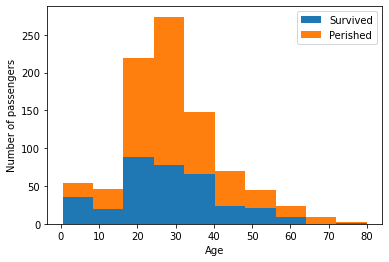

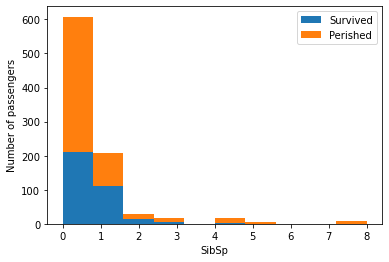

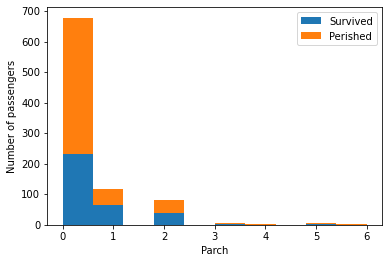

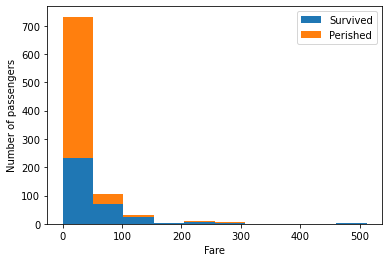

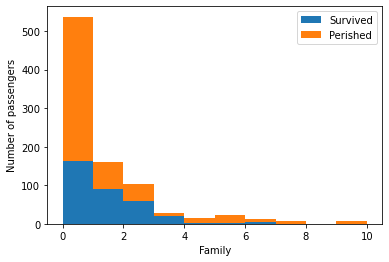

In [74]:
from matplotlib import pyplot as plt
for field in df_num:
    df_Survived = train_data[train_data['Survived'] == 1][field]
    df_Perished = train_data[train_data['Survived'] == 0][field]
    plt.hist([df_Survived, df_Perished],  stacked=True, label=['Survived', 'Perished'])
    plt.xlabel(field)
    plt.ylabel('Number of passengers')
    plt.legend()
    plt.show()

In [61]:
# correlations between numeric variables
df_num.corr(method='pearson').round(3)

,Age,SibSp,Parch,Fare,Family
Age,1.000,-0.250,-0.176,0.123,-0.258
SibSp,-0.250,1.000,0.415,0.160,0.891
Parch,-0.176,0.415,1.000,0.216,0.783
Fare,0.123,0.160,0.216,1.000,0.217
Family,-0.258,0.891,0.783,0.217,1.000


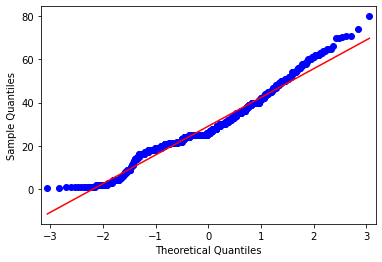

Shapiro Wilk: Sample does not look Gaussian (reject H0) 1.1187291327693916e-13
D'Agostino: Sample does not look Gaussian (reject H0) 1.7297932947642243e-11
Anderson: data does not look Gaussian at significance level 15.0 (reject H0)
Anderson: data does not look Gaussian at significance level 10.0 (reject H0)
Anderson: data does not look Gaussian at significance level 5.0 (reject H0)
Anderson: data does not look Gaussian at significance level 2.5 (reject H0)
Anderson: data does not look Gaussian at significance level 1.0 (reject H0)


In [42]:
# normality tests
def normal_tests(x):
    from scipy.stats import shapiro
    from scipy.stats import normaltest
    from scipy.stats import anderson
    alpha = 0.05

    # shapiro wilk test
    W, p_value = shapiro(x)
    if p_value > alpha:
        print('Shapiro Wilk: Sample looks Gaussian (fail to reject H0)', p_value)
    else:
        print('Shapiro Wilk: Sample does not look Gaussian (reject H0)', p_value)

    # d'agostino test
    stat, p_value = normaltest(x)
    if p_value > alpha:
        print("D'Agostino: Sample looks Gaussian (fail to reject H0)", p_value)
    else:
        print("D'Agostino: Sample does not look Gaussian (reject H0)", p_value)

    # anderson test
    result = anderson(x)
    for i in range(len(result.critical_values)):
        sl, cv = result.significance_level[i], result.critical_values[i]
        if result.statistic < result.critical_values[i]:
            print('Anderson: data looks Gaussian at significance level', sl, '(fail to reject H0)')
        else:
            print('Anderson: data does not look Gaussian at significance level', sl, '(reject H0)')

# visual and test results show it's not normal
from statsmodels.graphics.gofplots import qqplot
df_age = df_num['Age']
qqplot(df_age, line='s')
plt.show()
normal_tests(df_age)

In [ ]:
# can any data be normalised?
from statsmodels.graphics.gofplots import qqplot
from scipy.stats import yeojohnson
for feature in df_num:
    if feature != 'NormFare':
        print(feature)
        fitted_data, best_lambda = yeojohnson(df_num[feature])
        print('Lambda value used for transformation:', best_lambda)
        plt.hist(fitted_data)
        plt.show()
        qqplot(fitted_data, line='s')
        plt.show()
        normal_tests(fitted_data)
        print()

# Categorical Data

In [62]:
df_cat = train_data[['Survived', 'Pclass', 'Sex', 'Embarked', 'CabinType', 'AgeRange', 'GroupSize']]

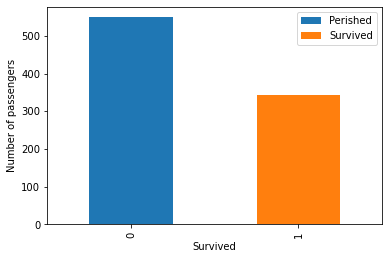

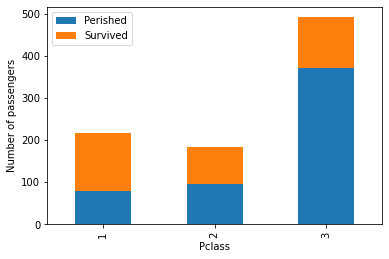

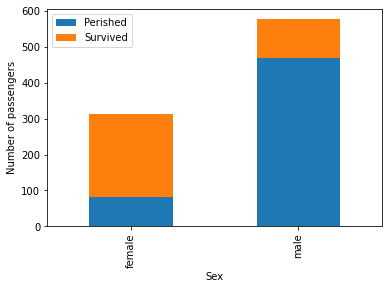

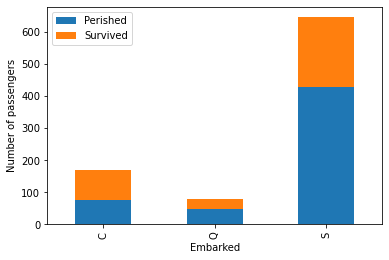

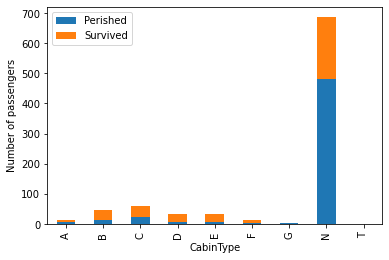

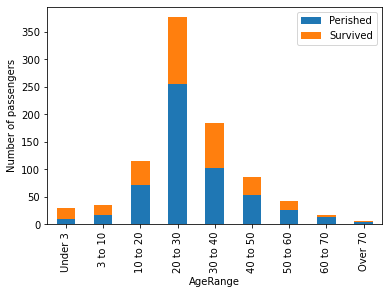

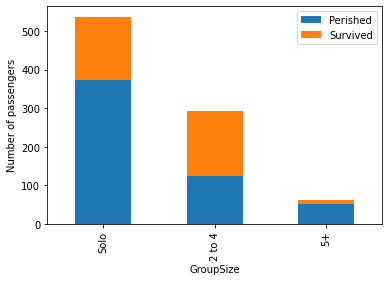

In [97]:
from matplotlib import pyplot as plt
for field in df_cat:
    #labels = ('Survived', 'Perished')
    df = train_data.groupby(field).apply(lambda x: x['Survived'].value_counts())
    df = df.unstack().fillna(0)
    df.plot.bar(stacked=True)
    plt.xlabel(field)
    plt.ylabel('Number of passengers')
    plt.legend(['Perished', 'Survived'])
    plt.show()

In [98]:
# independence of observations from two categorical variables
from scipy.stats import chi2_contingency
from scipy.stats import chi2

def check_independence(df, var1, var2):
    contingency_table = pd.crosstab(df[var1], df[var2], margins = False) 
    print(contingency_table) 

    # implement the Pearson's Chi-Squared test for independence
    stat, p, dof, expected = chi2_contingency(contingency_table)
    #print('\ndegrees of freedom (dof) = %d' % dof)
    #print(expected)

    # interpret test-statistic
    prob = 0.95
    critical = chi2.ppf(prob, dof)
    #print('probability=%.3f, critical=%.3f, stat=%.3f' % (prob, critical, stat))
    if abs(stat) >= critical:
        print('Test statistic indicates: Dependent (reject H0)')
    else:
        print('Test statistic indicates: Independent (fail to reject H0)')

    # interpret p-value
    alpha = 1.0 - prob
    #print('significance=%.3f, p=%.3f' % (alpha, p))
    if p <= alpha:
        print('p-value indicates: Dependent (reject H0)')
    else:
        print('p-value indicates: Independent (fail to reject H0)')
    print()

In [99]:
for field in df_cat:
    if field != 'Survived':
        check_independence(train_data, 'Survived', field)

Pclass      1   2    3
Survived              
0          80  97  372
1         136  87  119
Test statistic indicates: Dependent (reject H0)
p-value indicates: Dependent (reject H0)

Sex       female  male
Survived              
0             81   468
1            233   109
Test statistic indicates: Dependent (reject H0)
p-value indicates: Dependent (reject H0)

Embarked   C   Q    S
Survived             
0         75  47  427
1         93  30  219
Test statistic indicates: Dependent (reject H0)
p-value indicates: Dependent (reject H0)

CabinType  A   B   C   D   E  F  G    N  T
Survived                                  
0          8  12  24   8   8  5  2  481  1
1          7  35  35  25  24  8  2  206  0
Test statistic indicates: Dependent (reject H0)
p-value indicates: Dependent (reject H0)

AgeRange  Under 3  3 to 10  10 to 20  20 to 30  30 to 40  40 to 50  50 to 60  \
Survived                                                                       
0              10       16        71

# Tutorial Example

In [ ]:
# Random forest
from sklearn.ensemble import RandomForestClassifier
from sklearn import metrics

y = train_data['Survived']
features = ['Pclass', 'Sex', 'SibSp', 'Parch']
X = pd.get_dummies(train_data[features])
X_test = pd.get_dummies(test_data[features])

model = RandomForestClassifier(n_estimators=100, max_depth=5, random_state=1)
model.fit(X,y)
predictions = model.predict(X_test)

output = pd.DataFrame({'PassengerId' : test_data.PassengerId, 'Survived' : predictions})
print(output)

accuracy = metrics.accuracy_score(y_test, yhat)
print('accuracy', accuracy * 100)

# Feature Selection

In [ ]:
# Random forest
from sklearn.ensemble import RandomForestClassifier
from sklearn import metrics

# make a copy of the data
df = train_data.copy()

le_cabin = preprocessing.LabelEncoder()
le_cabin.fit(df.CabinType.unique())
df.CabinType = le_cabin.transform(df.CabinType)

le_embarked = preprocessing.LabelEncoder()
le_embarked.fit(df.Embarked.unique())
df.Embarked = le_embarked.transform(df.Embarked)

le_agerange = preprocessing.LabelEncoder()
le_agerange.fit(df.AgeRange.unique())
df.AgeRange = le_agerange.transform(df.AgeRange)

le_groupsize = preprocessing.LabelEncoder()
le_groupsize.fit(df.GroupSize.unique())
df.GroupSize = le_groupsize.transform(df.GroupSize)

# split the data into train and test
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.3, random_state=3)

y = df['Survived']
max_accuracy = 0
col_list = ['Pclass', 'SexId', 'Age', 'SibSp', 'Parch', 'Fare', 'CabinType', 'Embarked', 'Family', 'AgeRange', 'GroupSize']
for i in range(100): 
    # randomly select the order of fields to use in the decision tree
    shuffle(col_list) 
    # randomly select the number of fields to use in the decision tree
    num = randint(0,len(col_list) + 1)
    #num = 5
    X = df[col_list[0:num+1]] 

    # split the data into train and test
    X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.3, random_state=3)

    model = RandomForestClassifier(n_estimators=100, max_depth=10, random_state=1)
    model.fit(X,y)
    yhat = model.predict(X_test)

    accuracy = metrics.accuracy_score(y_test, yhat)
    if accuracy > max_accuracy:
        max_accuracy = accuracy
        accurate_fields = col_list[0:num+1]
print("Best Random Forest Accuracy: ", max_accuracy)
print('Using fields:', accurate_fields)

In [ ]:
# Decision Tree
from random import randint
from random import shuffle
from sklearn.tree import DecisionTreeClassifier
from sklearn import metrics
from sklearn import preprocessing

# make a copy of the data
df = train_data.copy()

le_cabin = preprocessing.LabelEncoder()
le_cabin.fit(df.CabinType.unique())
df.CabinType = le_cabin.transform(df.CabinType)

le_embarked = preprocessing.LabelEncoder()
le_embarked.fit(df.Embarked.unique())
df.Embarked = le_embarked.transform(df.Embarked)

le_agerange = preprocessing.LabelEncoder()
le_agerange.fit(df.AgeRange.unique())
df.AgeRange = le_agerange.transform(df.AgeRange)

le_groupsize = preprocessing.LabelEncoder()
le_groupsize.fit(df.GroupSize.unique())
df.GroupSize = le_groupsize.transform(df.GroupSize)

max_accuracy = 0
y = df['Survived'].values
col_list = ['Pclass', 'SexId', 'Age', 'SibSp', 'Parch', 'Fare', 'CabinType', 'Embarked', 'Family', 'AgeRange', 'GroupSize']
for i in range(1000): 
    # randomly select the order of fields to use in the decision tree
    shuffle(col_list) 
    # randomly select the number of fields to use in the decision tree
    num = randint(0,len(col_list) + 1)
    #num = 5
    X = df[col_list[0:num+1]] 

    # split the data into train and test
    X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.3, random_state=3)

    # create an instance of the DecisionTreeClassifier called credit_tree
    # inside the classifier, specify criterion="entropy" so we can see the information gain of each node
    survived_tree = DecisionTreeClassifier(criterion="entropy", max_depth = 10)
    survived_tree # it shows the default parameters

    # fit the data with the training feature matrix X-trainset, and training response vector y_trainset
    survived_tree.fit(X_train,y_train)

    # let's make some predictions on the testing dataset
    predTree = survived_tree.predict(X_test)

    # Accuracy classification score computes subset accuracy: the set of predicted labels must exactly match the corresponding set of labels in y_true
    accuracy = metrics.accuracy_score(y_test, predTree)
    if accuracy > max_accuracy:
        max_accuracy = accuracy
        accurate_fields = col_list[0:num+1]
print("Best DecisionTrees's Accuracy: ", max_accuracy)
print('Using fields:', accurate_fields)

In [ ]:
# SelectKBest
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import OrdinalEncoder
from sklearn.preprocessing import LabelEncoder
from sklearn.feature_selection import SelectKBest
from sklearn.feature_selection import chi2
from sklearn.linear_model import LogisticRegression
from sklearn.metrics import accuracy_score

# make a copy of the data
df = train_data.copy()

# split into input and output variables
col_list = ['Pclass', 'Sex', 'SibSp', 'Parch', 'CabinType', 'Embarked', 'Age', 'Fare', 'Family', 'AgeRange', 'GroupSize']
#col_list = ['Pclass', 'Sex', 'CabinType', 'Embarked', 'Fare', 'AgeRange', 'GroupSize']
X = df[col_list]
y = df['Survived']

# split into train and test sets
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.33, random_state=1)

# instantiate the OrdinalEncoder class to encode categorical input features
oe = OrdinalEncoder(handle_unknown='ignore')
# fit the OrdinalEncoder class on training set
oe.fit(X_train)
# transform training and test sets and convert to DFs
X_train_enc = pd.DataFrame(oe.transform(X_train), columns=X_train.columns)
X_test_enc = pd.DataFrame(oe.transform(X_test), columns=X_test.columns)

# instantiate the LabelEncoder class to encode the categorical target class
le = LabelEncoder()
# fit the LabelEncoder class on training set
le.fit(y_train)
# transform training and test target variables and convert to DFs
y_train_enc = pd.DataFrame(le.transform(y_train))
y_test_enc = pd.DataFrame(le.transform(y_test))

# instantiate SelectKBest class to select the best 4 features
# use score_func=mutual_info_classif for Mutual Information
# Use k='all' to see the scores for all features
max_accuracy = 0
for k_val in range(1, 7):   # if higher than 7 get a total no of iterations reached limit error
    fs = SelectKBest(score_func=chi2, k=k_val)
    # fit on training features and target
    fs.fit(X_train_enc, y_train_enc)
    # transform training and test features and convert to DFs. These will be fed to the ML algorithm for model training
    X_train_fs = pd.DataFrame(fs.transform(X_train_enc), columns = X_train_enc.columns[fs.get_support()])
    X_test_fs = pd.DataFrame(fs.transform(X_test_enc), columns = X_test_enc.columns[fs.get_support()])

    # define classification algorithm
    model = LogisticRegression()
    # fit the model
    model.fit(X_train_fs, y_train_enc.values.ravel())
    # predict
    yhat = model.predict(X_test_fs)
    # evaluate predictions
    accuracy = accuracy_score(y_test_enc, yhat)
    print('k, accuracy', k_val, accuracy)
    if accuracy >= max_accuracy:
        max_accuracy = accuracy
        cols = X_train_enc.columns[fs.get_support()]
print('Accuracy: %.2f' % (max_accuracy*100))
#print(X_train_enc.columns[fs.get_support()])
print(cols)

In [ ]:
# chi2_contingency - features with the lowest p values are shortlisted for modelling
from sklearn.model_selection import train_test_split
from scipy.stats import chi2_contingency
from sklearn.preprocessing import LabelEncoder
from sklearn.linear_model import LogisticRegression
from sklearn.metrics import accuracy_score

# make a copy of the data
df = train_data.copy()

# split into input and output variables
col_list = ['Pclass', 'Sex', 'SibSp', 'Parch', 'CabinType', 'Embarked', 'Age', 'Fare', 'Family', 'AgeRange', 'GroupSize']
X = df[col_list]
y = df['Survived'].values

# split into train and test sets
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.33, random_state=1)

# define an empty dictionary to store chi-test results
chi2_check = {}
# loop over each column in the encoded training set to calculate chi statistic with the target variable
for column in X_train:
    chi, p, dof, ex = chi2_contingency(pd.crosstab(y_train, X_train[column]))
    chi2_check.setdefault('Feature',[]).append(column)
    chi2_check.setdefault('p-value',[]).append(p)
# convert the dictionary to a DF
chi2_result = pd.DataFrame(data = chi2_check)
# print(chi2_result)
# select the top n features based on lowest p values
k = 5
top_chi2 = chi2_result.nsmallest(k, 'p-value')['Feature'].tolist()
print(top_chi2)

# filter out these shortlisted features into new DFs
X_train_fs = X_train[top_chi2]
X_test_fs = X_test[top_chi2]

# convert to shortlisted feature DFs into dummy variables
X_train_enc = pd.get_dummies(X_train_fs)
X_test_enc = pd.get_dummies(X_test_fs)
# reindex the dummied test set variables to make sure all the feature columns in the train set are also available in the test set
X_test_enc = X_test_enc.reindex(labels=X_train_enc.columns, axis=1, fill_value=0)

# instantiate the LabelEncoder class to transform target variable
le = LabelEncoder()
# fit the LabelEncoder class on training set
le.fit(y_train)
# transform training and test target variables and convert to DFs
y_train_enc = le.transform(y_train)
y_test_enc = le.transform(y_test)

# define classification algorithm
model = LogisticRegression()
# fit the model
model.fit(X_train_enc, y_train_enc)
# predict
yhat = model.predict(X_test_enc)
# evaluate predictions
accuracy = accuracy_score(y_test_enc, yhat)
print('Accuracy: %.2f' % (accuracy*100))

# Predictions
I have submitted these in no particular order, as a learning exercise

The standard submission based only on gender gives 76.55% accuracy on the test data

# Submission 1 - Random Forest
94% accuracy on the training data, but only 75.837% accuracy on the test data i.e. less accurate than the standard gender submission

In [25]:
# Most accurate random forest
from sklearn.ensemble import RandomForestClassifier
from sklearn import preprocessing

def prep_data(df):
    le_cabin = preprocessing.LabelEncoder()
    le_cabin.fit(df.CabinType.unique())
    df.CabinType = le_cabin.transform(df.CabinType)

    le_embarked = preprocessing.LabelEncoder()
    le_embarked.fit(df.Embarked.unique())
    df.Embarked = le_embarked.transform(df.Embarked)
    
    return df

# make a copy of the data
df = prep_data(train_data.copy())

# specify the features for the model
y = df['Survived']
col_list = ['Age', 'Fare', 'CabinType', 'Family', 'Embarked', 'Pclass', 'SibSp', 'SexId', 'Parch']
X = df[col_list] 

# fit the model
model = RandomForestClassifier(n_estimators=100, max_depth=10, random_state=1)
model.fit(X,y)

# run the model on the test data
test_data = prep_data(test_data)
test_data.reindex(columns=df.columns, fill_value=0)
predictions = model.predict(test_data[col_list])
output = pd.DataFrame({'PassengerId' : test_data.PassengerId, 'Survived' : predictions})
output.to_csv('my_submission_1.csv', index=False)

# Submission 2 - Decision Tree
83.58% accuracy on the training data but only 77.99% accuracy on the test data

In [26]:
from sklearn.tree import DecisionTreeClassifier
from sklearn import preprocessing

def prep_data(df):
    le_cabin = preprocessing.LabelEncoder()
    le_cabin.fit(df.CabinType.unique())
    df.CabinType = le_cabin.transform(df.CabinType)

    le_embarked = preprocessing.LabelEncoder()
    le_embarked.fit(df.Embarked.unique())
    df.Embarked = le_embarked.transform(df.Embarked)
    
    return df
    
# make a copy of the data
df = prep_data(train_data.copy())

# specify the features for the model
y = df['Survived'].values
col_list = ['Pclass', 'SexId', 'Fare', 'Embarked']
X = df[col_list] 

# create an instance of the DecisionTreeClassifier 
# inside the classifier, specify criterion="entropy" so we can see the information gain of each node
model = DecisionTreeClassifier(criterion="entropy", max_depth = 10)
model # it shows the default parameters

# fit the data with the training feature matrix X-trainset, and training response vector y_trainset
model.fit(X, y)

# run the model on the test data
test_data = prep_data(test_data)
test_data.reindex(columns=df.columns, fill_value=0)
predictions = model.predict(test_data[col_list])
output = pd.DataFrame({'PassengerId' : test_data.PassengerId, 'Survived' : predictions})
output.to_csv('my_submission_2.csv', index=False)

# Submission 3 - SelectKBest
77.29% accuracy on training data but only 75.119% on test data so, again, less accurate than standard gender submission

In [27]:
from sklearn.preprocessing import OrdinalEncoder
from sklearn.preprocessing import LabelEncoder
from sklearn.feature_selection import SelectKBest
from sklearn.feature_selection import chi2
from sklearn.linear_model import LogisticRegression

def prep_data(X):
    # instantiate the OrdinalEncoder class to encode categorical input features
    oe = OrdinalEncoder(handle_unknown='ignore')
    # fit the OrdinalEncoder class on training set
    oe.fit(X)
    # transform training and test sets and convert to DFs
    return pd.DataFrame(oe.transform(X), columns=X.columns)

# make a copy of the data
df = train_data.copy()

# split into input and output variables
col_list = ['Pclass', 'Sex', 'Parch', 'CabinType', 'Age', 'Fare']
X = df[col_list]
y = df['Survived']

# encode input features and target class
X_enc = prep_data(X)

# instantiate the LabelEncoder class to encode the categorical target class
le = LabelEncoder()
# fit the LabelEncoder class on training set
le.fit(y)
# transform training and test target variables and convert to DFs
y_enc = pd.DataFrame(le.transform(y))

# instantiate SelectKBest class to select the best k features
# use score_func=mutual_info_classif for Mutual Information
# Use k='all' to see the scores for all features
k_val = 'all'
fs = SelectKBest(score_func=chi2, k=k_val)
# fit on training features and target
fs.fit(X_enc, y_enc)
# transform training and test features and convert to DFs. These will be fed to the ML algorithm for model training
X_fs = pd.DataFrame(fs.transform(X_enc), columns = X_enc.columns[fs.get_support()])

# define classification algorithm
model = LogisticRegression()
# fit the model
model.fit(X_fs, y_enc.values.ravel())

# run the model on the test data
X_test = prep_data(test_data[col_list])
predictions = model.predict(X_test)
output = pd.DataFrame({'PassengerId' : test_data.PassengerId, 'Survived' : predictions})
output.to_csv('my_submission_3.csv', index=False)